<a href="https://colab.research.google.com/github/jleon253/curso_computacion_cuantica/blob/main/Proyecto_final/John_Edward_Leon_Munoz/John_Edward_Leon_Munoz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Applying Grover’s algorithm to AES:**
### *Quantum resource estimates*

# Initial install: ⏭ 👀 Needs IBM Quantum Token (please, expand this section) 👀 ⏮

## Quiskit

In [ ]:
!pip install git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src

## Imports

In [2]:
from qiskit import QuantumCircuit, execute
from qiskit.visualization import array_to_latex, plot_histogram

from qiskit import IBMQ, Aer, assemble, transpile
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor

from math import *
from random import randrange
import matplotlib.pyplot as plt
import numpy as np

## IBM Quantum Token:

In [ ]:
API_TOKEN = input("Enter token for IBM Quantum: ")

IBMQ.enable_account(API_TOKEN)

## Utilities

In [4]:
def display_unitary(qc, prefix="U_\\text{oracle}="):
    sim = Aer.get_backend('aer_simulator')
    qc = qc.copy()
    qc.save_unitary()
    unitary = sim.run(qc).result().get_unitary()
    display(array_to_latex(unitary, prefix=prefix))

# **Personal info**



In [5]:
__author__    = "John Edward León Muñoz"
__credits__   = ["John Edward León Muñoz"]
__copyright_amp__ = "(c) John Edward León Muñoz"
__code__ = "20212678013"
__email__   = "jeleonm@correo.udistrital.edu.co"



---



# **01: Investigation**

## Glosary

### **Quantum Oracle:**

Is a black box used extensively in quantum algorithms for the estimation of functions using qubits. Estimation in a classical computer is set up with an $n$-dimensional input $x$ producing an $m$-dimensional output $f(x)$


$$
f : \left\{ 0,1 \right\}^{n} \longrightarrow \left\{ 0,1 \right\}^{m}
$$

The $n$-dimensional vector $x$ is encoded as quantum information by considering $n$ qubits each storing a single bit of information as below

$$
|x \rangle = \ |x_0 \rangle \ \otimes |x_1 \rangle \ \otimes \ ... \ \otimes \ |x_{n-1} \rangle
$$

Quantum oracles help transform a system from a quantum state $|x \rangle$ into a state $|f(x) \rangle$, through the evolution of quantum states.

## What?

**Grover's algorithm** refers to a quantum algorithm for unstructured search that finds with high probability the unique input to a black box function that produces a particular output value, using just $ O(\sqrt{N})$ evaluations of the function, where $ N $ is the size of the function domain.

The analogous problem in classical computation can't be solved in fewer that $ O(N) $ evaluations (because, on average, one has to check half of the domain to get a 50% chance of finding the right input).

Unlike other quantum algorithms, wich may provide exponential speed up over their classical counterparts, Grover's algorithm provides only a quadratic speed up. However, even quadratic speed up is considerable when $ N $ is large and Grover's algorithm can be applied to speed up broad classes of algorithms.

Also, it can serve as a general trick or subroutine to obtain quadratic run time improvements for a variety of other algorithms. This is called *the amplitude amplification trick*.

Grover's algorithm could apply **brute force** a 128-bit symmetric cryptographic key in roughly $2^{64}$ iterations, or a 256-bits key in roughly $2^{128}$ iterations.

As a result, it is sometimes suggested that symmetric key lengths be doubled to protect against future quantum attacks.

Grover's algorithm essentially solves the task of *function inversion*. Namely, if we have a fucntion $y = f(x)$ that can be evaluated on a quantum computer, Grover's algorithm allows us to calculate $x$ when given $y$.

It's of a probabilistic nature, which is why it produces the correct answer with a certain probability of error, however, it can be obtained as low as desired through iterations.

## How?

### Unstructured Search

Suppose you are given a large list of $N$ items. Among these items there is one item with a unique property that we wish to locate; we will call this one the winner $w$. Think of each item in the list as a box of a particular color. Say all items in the list are gray except the winner $w$, which is purple.

![image1](https://qiskit.org/textbook/ch-algorithms/images/grover_list.png)

To find the purple box -- the *marked item* -- using classical computation, one would have to check on average $N/2$ of these boxes, and in the worst case, all $N$ of them. On a quantum computer, however, we can find the marked item in roughly $\sqrt{N}$ steps with Grover's amplitude amplification trick.

Additionally, the algorithm does not use the list's internal structure, which makes it *generic;* this is why it immediately provides a quadratic quantum speed-up for many classical problems.

### Creating an Oracle

Our 'database' is comprised of all the possible computational basis states our qubits can be in. For example, if we have 3 qubits, our list is the states $|000\rangle, |001\rangle, \dots |111\rangle$ (i.e the states $|0\rangle \rightarrow |7\rangle$).

Grover’s algorithm solves oracles that add a negative phase to the solution states. I.e. for any state $|x\rangle$ in the computational basis:

$$
U_\omega|x\rangle = \bigg\{
\begin{aligned}
\phantom{-}|x\rangle \quad \text{if} \; x \neq \omega \\
-|x\rangle \quad \text{if} \; x = \omega \\
\end{aligned}
$$

This oracle will be a diagonal matrix, where the entry that correspond to the marked item will have a negative phase. For example, if we have three qubits and $\omega = \text{101}$, our oracle will have the matrix:

$$
U_\omega = 
\begin{bmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & -1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\
\end{bmatrix}
\begin{aligned}
\\
\\
\\
\\
\\
\\
\leftarrow \omega = \text{101}\\
\\
\\
\\
\end{aligned}
$$

For these problems, we can create a function $f$ that takes a proposed solution $x$, and returns $f(x) = 0$ if $x$ is not a solution ($x \neq \omega$) and $f(x) = 1$ for a valid solution ($x = \omega$). Our oracle can then be described as:

$$
U_\omega|x\rangle = (-1)^{f(x)}|x\rangle
$$

and the oracle's matrix will be a diagonal matrix of the form:

$$
U_\omega = 
\begin{bmatrix}
(-1)^{f(0)} &   0         & \cdots &   0         \\
0           & (-1)^{f(1)} & \cdots &   0         \\
\vdots      &   0         & \ddots & \vdots      \\
0           &   0         & \cdots & (-1)^{f(2^n-1)} \\
\end{bmatrix}
$$

### Amplitude amplification procedure

We haven't idea where the marked item is. Therefore, any guess of its location is as good as any other, which can be expressed in terms of a
uniform superposition: $|s \rangle = \frac{1}{\sqrt{N}} \sum_{x = 0}^{N -1} | x
\rangle.$

If at this point we were to measure in the standard basis $\{ | x \rangle \}$, this superposition would collapse, according to the fifth quantum law, to any one of the basis states with the same probability of $\frac{1}{N} = \frac{1}{2^n}$. Our chances of guessing the right value $w$ is therefore $1$ in $2^n$, as could be expected. Hence, on average we would need to try about $N/2 = 2^{n-1}$ times to guess the correct item.

Here enter the procedure called **amplitude amplification**, which is how a quantum computer significantly enhances this probability. This procedure stretches out (amplifies) the amplitude of the marked item, which shrinks the other items' amplitude, so that measuring the final state will return the right item with near-certainty. 

The procedure is the next:

**Step 1:**

The amplitude amplification procedure starts out in the uniform superposition $| s \rangle$, which is easily constructed from $| s \rangle = H^{\otimes n} | 0 \rangle^n$.

![image2](https://qiskit.org/textbook/ch-algorithms/images/grover_step1.jpg)

The left graphic corresponds to the two-dimensional plane spanned by perpendicular vectors $|w\rangle$ and $|s'\rangle$ which allows to express the initial state as $|s\rangle = \sin \theta | w \rangle + \cos \theta | s' \rangle,$ where $\theta = \arcsin \langle s | w \rangle = \arcsin \frac{1}{\sqrt{N}}$. The right graphic is a bar graph of the amplitudes of the state $| s \rangle$.

**Step 2:**

We apply the oracle reflection $U_f$ to the state $|s\rangle$.

![image3](https://qiskit.org/textbook/ch-algorithms/images/grover_step2.jpg)

Geometrically this corresponds to a reflection of the state $|s\rangle$ about $|s'\rangle$. This transformation means that the amplitude in front of the $|w\rangle$ state becomes negative, which in turn means that the average amplitude (indicated by a dashed line) has been lowered.

**Step 3:**

We now apply an additional reflection ($U_s$) about the state $|s\rangle$: $U_s = 2|s\rangle\langle s| - I$ . This transformation maps the state to $U_s U_f| s \rangle$ and completes the transformation.

![image4](https://qiskit.org/textbook/ch-algorithms/images/grover_step3.jpg)

Two reflections always correspond to a rotation. The transformation $U_s U_f$ rotates the initial state $|s\rangle$ closer towards the winner $|w\rangle$. The action of the reflection $U_s$ in the amplitude bar diagram can be understood as a reflection about the average amplitude. Since the average amplitude has been lowered by the first reflection, this transformation boosts the negative amplitude of $|w\rangle$ to roughly three times its original value, while it decreases the other amplitudes. We then go to **step 2** to repeat the application. This procedure will be repeated several times to zero in on the winner. 

After $t$ steps we will be in the state $|\psi_t\rangle$ where: $| \psi_t \rangle = (U_s U_f)^t  | s \rangle.$

**How many times do we need to apply the rotation?**

It turns out that roughly $\sqrt{N}$ rotations suffice. This becomes clear when looking at the amplitudes of the state $| \psi \rangle$. We can see that the amplitude of $| w \rangle$ grows linearly with the number of applications $\sim t N^{-1/2}$. However, since we are dealing with amplitudes and not probabilities, the vector space's dimension enters as a square root. Therefore it is the amplitude, and not just the probability, that is being amplified in this procedure.

In the case that there are multiple solutions, $M$, it can be shown that roughly $\sqrt{(N/M)}$ rotations will suffice.

![image5](https://qiskit.org/textbook/ch-algorithms/images/grover_circuit_high_level.png)

### Example with 2 Qubits

We now implement Grover's algorithm for 2 qubits and $\lvert w \rangle = |11\rangle$.

In [6]:
# We start by preparing a quantum circuit with two qubits:
n = 2
groverC = QuantumCircuit(n)

we need to initialize the state $|s\rangle$. Let's create a general function (for any number of qubits) so we can use it again later:

In [7]:
def initialize_s(qc, qubits):
    """Apply a H-gate to 'qubits' in qc"""
    for q in qubits:
        qc.h(q)
    return qc

In [8]:
groverC = initialize_s(groverC, [0,1])
groverC.draw()

┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ H ├
     └───┘

We'll invert the phase applying the Oracle for the state $|w\rangle = |11\rangle$

In [9]:
# Oracle

oracle = QuantumCircuit(n)
oracle.cz(0,1)

oracle.draw()

q_0: ─■─
      │ 
q_1: ─■─

We now want to apply the diffuser ($U_s$)

In [10]:
# Diffusion operator U_s

diffuser = QuantumCircuit(n)
diffuser = initialize_s(diffuser, [0,1])
diffuser.z([0,1])
diffuser.cz(0,1)
diffuser.h([0,1])

diffuser.draw()

┌───┐┌───┐   ┌───┐
q_0: ┤ H ├┤ Z ├─■─┤ H ├
     ├───┤├───┤ │ ├───┤
q_1: ┤ H ├┤ Z ├─■─┤ H ├
     └───┘└───┘   └───┘

We now have two circuits, oracle and diffuser, so we can put this together into a circuit that performs Grover's algorithm. Remember the three steps:


1.   Initialise the qubits to the state $|s\rangle$
2.   Perform the oracle
3.   Perform the diffuser



In [11]:
# Adding the oracle to Grover circuit
groverC = groverC.compose(oracle)

# Adding the diffuser to Grover circuit
groverC = groverC.compose(diffuser)

groverC.measure_all()
groverC.draw()

┌───┐   ┌───┐┌───┐   ┌───┐ ░ ┌─┐   
   q_0: ┤ H ├─■─┤ H ├┤ Z ├─■─┤ H ├─░─┤M├───
        ├───┤ │ ├───┤├───┤ │ ├───┤ ░ └╥┘┌─┐
   q_1: ┤ H ├─■─┤ H ├┤ Z ├─■─┤ H ├─░──╫─┤M├
        └───┘   └───┘└───┘   └───┘ ░  ║ └╥┘
meas: 2/══════════════════════════════╩══╩═
                                      0  1

And when we simulate, we can see a 100% probability of measuring , which was the solution to our oracle!

In [12]:
sim = Aer.get_backend('aer_simulator')
sim.run(groverC).result().get_counts()

{'11': 1024}

In [13]:
groverC_sim = groverC.copy()
groverC_sim.save_statevector()
qObj = assemble(groverC_sim)
result = sim.run(qObj).result().get_statevector()

array_to_latex(result, prefix="|\\psi\\rangle =")

<IPython.core.display.Latex object>

As expected, the amplitude of every state that is not $|11\rangle$ is 0, this means we have a 100% chance of measuring $|11\rangle$:

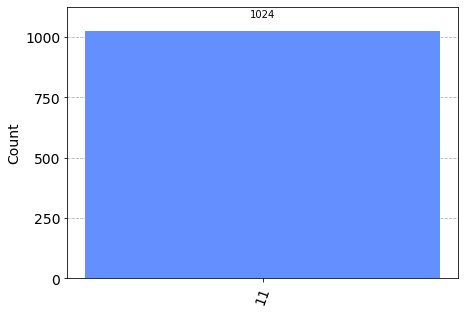

In [14]:
counts = sim.run(groverC).result().get_counts()
plot_histogram(counts)

Experiment with real devices

Running on current least busy device:  ibmq_belem
Executing Job...

Job Status: job has successfully run


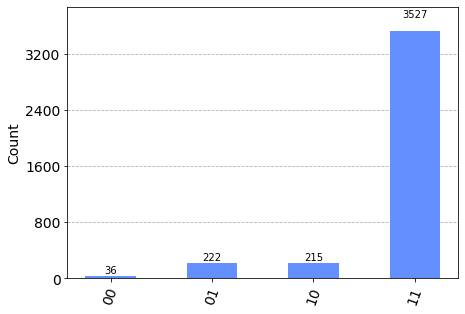

In [15]:
provider = IBMQ.get_provider(hub='ibm-q')

device = least_busy(provider.backends(filters=lambda x: int(x.configuration().n_qubits) >= 3 and 
                                   not x.configuration().simulator and x.status().operational==True))
print("Running on current least busy device: ", device)

groverC_transpiled = transpile(groverC, device, optimization_level=3)
job = device.run(groverC_transpiled)
print('Executing Job...\n')
job_monitor(job, interval=2)

answer = job.result().get_counts(groverC)
plot_histogram(answer)

We confirm that in the majority of the cases the state $|11\rangle$ is measured. The other results are due to errors in the quantum computation.

### Overview of Grover's algorithm

![image6](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b9/Grover%27s_algorithm_circuit.svg/1024px-Grover%27s_algorithm_circuit.svg.png)

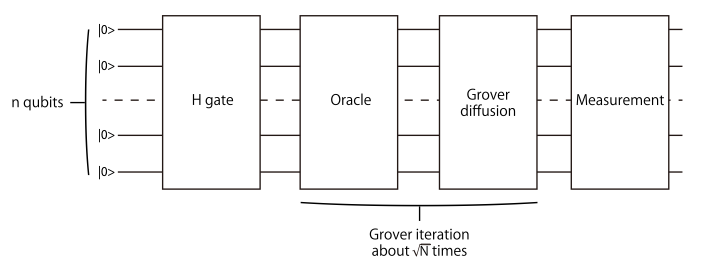

## When?

It was devised by Lov Grover in 1996 and won renown as the second major algorithm proposed for quantum computing (after Shor's 1994 algorithm), and in 2017 was finally implemented in a scalable physical quantum system.

\\

In his paper "*From Schrödinger's Equation to the Quantum Search Algorithm*", Lov Grover wrote on how he came up with his search algorithm and there are three main sources of inspiration:



**Physical inspiration:**

He talks about how quantum systems just like classical ones "move" towards points with low potential. Such a system let to evolve "finds"/"searches" for the point with the lowest potential because after some time left for the system to evolve, that state accumulates more probability amplitude.

**Discretisation:**

He uses Schrodinger's equation but considers evolution for one infinitesimal amount of time and he also considers a quantum state over a finite set of points. He derives matrices whose effect is to evolve this quantum system for an infinitesimal amount of time where all of the finite set of points have the same potential, except one marked point with lower potential. He mentions Trotterisation, which is delightful because on reflection Grover's algorithm does indeed have that alternation of two unitary operators like a Trotter approximation.

**Unitarification:**

He tries to find Unitary versions of his discretised evolution matrices. For a while in the explanation he goes "off road" to just think about the "diffusion" of amplitude towards the marked state in terms of matrices which are Markovian but not unitary. He later tries to find unitary approximations to these so that they can be implemented on a quantum computer.

## Where?

The Grover's algorithm can be applied in different areas, such as:

**NP-complete problems:**

This algorithms contain exhaustive search as a subroutine, which can be speed up by Grover's algorithm. E.g: 3SAT

**Generic constraint satisfaction problems:**

This problems also see quadratic speed ups with Grover, because this algorithms don't require that the input be given in the form of an oracle, since Grover's algorithm is being applied with an explicit function.

**Black-box problems in quantum query complexity:**

Decision tree model, includin element distinctness and the collision problem. In these type of problems, one treats the oracle function $f$ as a database, and the goal is to use the quantum query to this function as few times as possible.

**Cryptography:**

Grover's algorithm essentially solves the task of *function inversion*. Consequently, Gorver's gives board asymptotic speed ups to many kinds of brute-force attacks on symmetric-key cryptography, including collision attacks and pre image attacks.

# **02: Implementation**

## Description

We now present an implementation of Grover's algorithm using IBM's Qiskit framework. The program considers a variable n-qubit register,
whose possible states encode the elements of the search space. Since the algorithm itself relies
on repeated applications of the same transformation, the implementation takes into account
this modular feature and it contains subcircuits, which are then attached together to build the
larger circuit.

The program allows us to explicitly specify the solution state as an $n$-bit string or it can
be chosen randomly from the set of all $N = 2^{n}$ values. Either way, the function that de nes
the e ect of the oracle has a general implementation that will properly mark the selected state.

Furthermore, the oracle and the di usion transformation are subcircuits that adapt with the chosen number of qubits $n$. The algorithm can be either simulated using Qiskit's internal simulator or it can be executed remotely on IBM's available backends, including real devices.
The output of the program gives information about the backend that is being used, the searched state, the ideal number of iterations and an associative array indicating the statistical results following measurements.

After of that,  we'll establish
precise bounds for the number of qubits and the number of elementary logical quantum gates that are needed to
implement Grover’s quantum algorithm for all three variants of AES (key size 128, 192, and 256 bit)

## Simulation

In [16]:
#=== FUNCTION DEFINITIONS #===
# n-bit binary representation of integer
def bst(n,s):
    return str(bin(s)[2:].rjust(n,'0'))


# subcircuit applying gates given as arguments to every qubit
def gn(n,*args):
    qc = QuantumCircuit(n,n)
    for i in range(n):
        for gate in args:
            getattr(qc, gate)(i)
    return qc


# subcircuit implementing the oracle
def oracle(n,s):
    # adds phase shift only to state corresponding to "s"
    qc = QuantumCircuit(n,n)
    for i in range(n):
        if s[n-1-i] == "0":
            qc.x(i)

    # applies CZ gate with controls 0:n-2 and target n-1
    qc.h(n-1)
    qc.mcx(list(range(n-1)),n-1)
    qc.h(n-1)
    for i in range(n):
        if s[n-1-i] == "0":
            qc.x(i)

    qc.barrier()
    return qc


# subcircuit implementing the diffusion transformation
def diffusion(n):
    # amplifies the probability amplitude of the solution state
    qc = QuantumCircuit(n,n)
    qc.compose(gn(n,"h","x"))

    qc.h(n-1)
    qc.mcx(list(range(n-1)),n-1)

    qc.h(n-1)

    qc.compose(gn(n,"x","h"))

    qc.barrier()
    return qc


# subcircuit implementing a single Grover iteration
def grover_iteration(n,s):
    qc = QuantumCircuit(n,n)
    qc.compose(oracle(n,s))
    qc.compose(diffusion(n))
    return qc

# custom histogram plot
def show_results(counts,shots,iterations,comment):
    states = list(counts.keys())
    outcomes = list(counts.values())
    prob = [round(i/shots,3) for i in outcomes]

    d = dict(zip(states,prob))
    d = dict(sorted(d.items()))
    states = list(d.keys())
    prob = list(d.values())

    bp = plt.bar(states,prob,color='deepskyblue',zorder=2)

    for i in bp:
        h = i.get_height()
        if h > 0.001:
            plt.text(i.get_x(), h + 0.025, h)

    plt.ylim(0,1.1)
    plt.yticks(np.arange(0,1.25,0.25))
    plt.ylabel("Probabilities")
    plt.grid(axis='y',linestyle='dashed',zorder=0)
    plt.title("Results after " + str(iterations) + " iteration(s), " + comment)
    plt.show()

In [17]:
#=== INITIAL PARAMETERS #===

# size of quantum and classical registers
n = 2

# size of the search space
N = 2**n

# ideal number of iterations
k = floor(pi/4*sqrt(N))

In [18]:
#=== EXPERIMENT TYPE #===
# local simulation, remote simulation, execution on real device
exp_type = "real"

if exp_type == "local":
    backend = Aer.get_backend('qasm_simulator')
else:
    #provider = IBMQ.load_account()
    provider = IBMQ.get_provider(hub='ibm-q')
    if exp_type == "real":
        backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= n and not x.configuration().simulator and x.status().operational==True))
    elif exp_type == "hpc":
        backend = provider.get_backend('ibmq_qasm_simulator')

BACKEND: ibmq_belem
SEARCHING FOR |11>
REQUIRED ITERATIONS: 1
Job Status: job has successfully run
RESULTS: {'00': 1985, '01': 9, '10': 6}


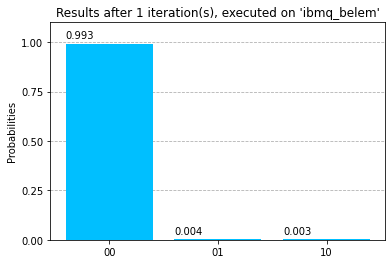

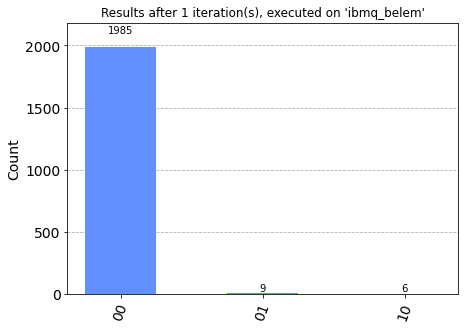

In [19]:
#=== SEARCHED ELEMENT #===

s = randrange(N)
s = bst(n,s)
#s = "001"
print("BACKEND: " + str(backend))
print("SEARCHING FOR |" + s + ">")
print("REQUIRED ITERATIONS: " + str(k))

grc = QuantumCircuit(n,n)

# CREATE INITIAL SUPERPOSITION
grc.compose(gn(n,"h"))

# REPEAT UNTIL THE IDEAL NUMBER OF ITERATIONS IS REACHED
for iteration in range(k):
    grc.compose(grover_iteration(n,s))

# MEASURE AT THE END
grc.measure(list(range(n)),list(range(n)))

# number of circuit instances to be measured
shots = 2000

if exp_type == "local":
    result = execute(grc,backend,shots=shots).result()
    comment = "locally simulated"

elif exp_type == "real" or exp_type == "hpc":
    job_grc = execute(grc, backend, shots=shots)
    job_monitor(job_grc)
    result = job_grc.result()
    comment = "executed on '" + str(backend) + "'"

counts = result.get_counts(grc)
print("RESULTS: " + str(counts))

show_results(counts,shots,k,comment)
plot_histogram(counts, title="Results after " + str(k) + " iteration(s), " + comment)

### Simulation

As $n$ increases, the probability $p$ associated with the marked state approaches 1 after the required number of iterations $k$ is reached.

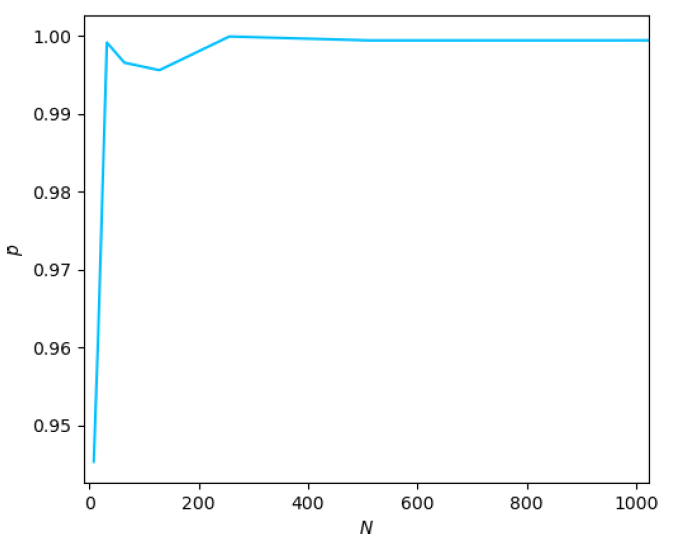

* For $n = 2$ actually indicates an impressive start. After just one iteration, the probability of the solution state is boosted to exactly 1. In this case, state $|10\rangle$ was selected at random and out of all 2000 preparations of the qubit register and runs of the algorithm, the desired
state came out every time after measurement. 

* For $n = 3$, the calculated probability of finding the solution after $k = 2$ iterations is about 0.945. One experiment reveals that state $|010\rangle$ is found with probability 0.946, while the others are negligible.

* For $n = 5$, the histogram shows that the measurement returned $|01100\rangle$ almost every time (1998 instances), with only two other states observed very rarely (one instance each). 

* For an even larger $n = 16$, some executions might return the marked state with probability 1, which justifies the eficiency of the algorithm.

### Execution on real devices

Running Grover's algorithm on a real quantum computer comes with reasonable limitations.

* First of all, the size of the quantum register can be no greater than the actual number of qubits
of the physical chip. Then, the experiments are no longer noise-free and the performance
of the algorithm strongly depends on other factors, such as the partial connectivity of the
architecture, qubit quality and gate errors.

* Each backend has a queue where jobs are pending
for execution. In order to manage this aspect more easily, IBM's framework can select the
least busy backend when someone decides to run a program. 

* For $n = 2$, the algorithm ran on ibmq london, a 5-qubit processor. The results are visibly di erent from the ideal case we previously discussed. Now, marked state $|11\rangle$ returns from the 2000 measurements only 1781 times, thus having a probability of about 0.89 instead of exactly 1. The other states
have non-zero amplitudes because of the processor's intrinsic computation errors.

* For $n = 3$, the probability of the state is increased to merely 0.256 after the iterations are finished. The distribution is still unimodal, although the performance degrades once $n$ increases and the solution is no longer distinguishable.

### Resource estimates: Grover algorithm

Denoting by $s_k$ the total number of qubits, $t_k$ the total number of $T$-gates, $c_k$ the total number of Clifford gates, $\delta_k$ the overall $T$-depth and $\Delta_k$ the overall depht, where $k=$128, 192, 156, the we obtain the following estimates for the overall Grover's algorithm. 

The space requirements are: 
* $3s_{128}$ + 1 qubits for AES-128
* $4s_{192}$ + 1 qubits for AES-192
* $5s_{256}$ + 1 qubits for AES-256

For the overall circuit depht we obtain the number of rounds times 2 times $\delta_k$, respectly $\Delta_k$, ignoring some of the gates which do not contribute significantly to the bottom line. The overall quantum resource estimates are:

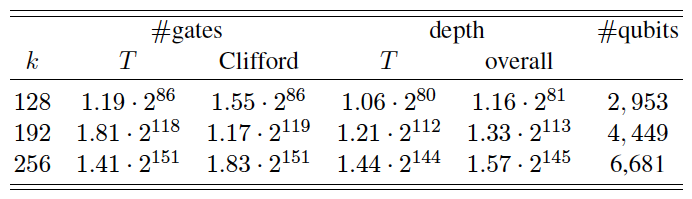

# 03: Conclusion

One of our main findings is that the number of logical qubits required to implement a Grover attack on AES is relatively low, namely between around 3.000 and 7.000 logical qubits. However, due to the large circuit depth of unrolling the entire Grover iteration, it seems challenging to implement this algorithm on an actual physical quantum computer, even if the gates are not error corrected. It is worth noting that much of the circuit cost within each Grover iteration originates from the key expansion, i. e., from deriving the round keys and that the overall depth is a direct result of the serial nature of Grover’s algorithm.

With the promising advancements in the realization of quantum computation devices, the threat to modern cryptographic schemes becomes an issue of importance for the future.

As we have explored in this work, Grover's algorithm cannot be fully exploited yet because of the practical limitations and challenges that hinder the accuracy of quantum computation. However, its theoretical e ciency makes it a highly valuable tool as a searching algorithm. 

From a security perspective, it is even more captivating, as it signi cantly improves the primary and most straightforward type of attack against symmetric ciphers.

# 04: References

* https://qiskit.org/textbook/ch-algorithms/grover.html
* https://learn.qiskit.org/course/introduction/grovers-search-algorithm#grovers-19-0
* https://qiskit.org/documentation/locale/es_UN/tutorials/algorithms/06_grover.html
* https://en.wikipedia.org/wiki/Grover%27s_algorithm
* https://medium.com/@brcsomnath/qml-quantum-oracle-c8a48cdaf851
* https://arxiv.org/abs/quant-ph/0109116




In [20]:
import qiskit.tools.jupyter
%qiskit_version_table